In [1]:
import numpy as np
import synapseclient
import os
import sys
import pandas
import pylab as pl

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pylab as pl
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
syn = synapseclient.login()

Welcome, Abhishek Pratap!



In [3]:
def get_truePhenotype_testSamples_RA_challenge(syn):
    """
    function to get the read the true phenotype values for the testSamples
    """
    #get the phenotype data
    phenotype_data_synId = 'syn2324939'
    phenotype_data_entity = syn.get(phenotype_data_synId)
    phenotype_df = pandas.DataFrame.from_csv(header=0, sep=" ", path=phenotype_data_entity.path)
    phenotype_df = phenotype_df.reset_index()
    #renaming column 'ID_1' to 'ID'
    phenotype_df['ID'] = phenotype_df.ID_1
    phenotype_df = phenotype_df.drop(['ID_1'], axis=1)

    #get the partitions and extract the testSamples ID  (test1 == 1)
    partition_data_synId = 'syn2351768'
    partition_data_entity = syn.get(partition_data_synId)
    partitions_df = pandas.DataFrame.from_csv(partition_data_entity.path,header=0,sep=" ")
    partitions_df = partitions_df.reset_index()

    #the following generates warning 
    #testSamples_ID = partitions_df.query('test1 == 1')['ID']
    testSamples_ID = partitions_df[partitions_df['test1'] == 1]['ID']

    #return only the phenotypes for the testSamples set
    #testSamples_true_phenotype = phenotype_df.query('ID == testSamples_ID')
    testSamples_true_phenotype = phenotype_df[phenotype_df.ID.isin(testSamples_ID)]
    return (testSamples_true_phenotype)

In [4]:
truth_df = get_truePhenotype_testSamples_RA_challenge(syn)

####creating binary class for Precision Recall calculation 
* 1 = non responder
* 0 = responder

In [5]:
truth_df['true_class'] = np.nan
truth_df.true_class[truth_df.Response.isin(['Intermediate', 'Good'])] = 0
truth_df.true_class[truth_df.Response.isin(['Non', 'Supernon'])] = 1

In [6]:
def __get_blockWise_stats(sub_stats):
    
    #group to calculate group wise stats for each block
    grouped = sub_stats.groupby(['predict'], sort=False)
    
    #instantiate a pandas dataframe to store the results for each group (tied values)
    result = pandas.DataFrame.from_dict({'block':xrange(len(grouped)),
                                         'block_numElements'  : np.nan,
                                         'block_truePos_density' : np.nan,
                                         'block_truePos'      : np.nan,
                                         'blockValue'   : np.nan
                                         })
    
    for block,grp in enumerate(grouped):
        name,grp = grp[0],grp[1]
        truePositive = sum(grp.truth == 1)
        grp_truePositive_density = truePositive / float(len(grp))
        idxs = result.block == block
        result.block_truePos_density[idxs] = grp_truePositive_density
        result.block_numElements[idxs] = len(grp)
        result.block_truePos[idxs] = truePositive
        result.blockValue[idxs] = grp.predict.unique()
    result.block = result.block + 1
    result['cum_numElements'] = result.block_numElements.cumsum()
    result['cum_truePos'] = result.block_truePos.cumsum()
    
    return(result)

In [7]:
def get_precision_recall_fpr(truth, pred):
    
    sub_stats = pandas.DataFrame.from_dict({'predict':pred, 'truth':truth}, dtype='float64')
    sub_stats = sub_stats.sort_values(by=['predict'],ascending=False)

    blockWise_stats = __get_blockWise_stats(sub_stats)
    grouped = sub_stats.groupby(['predict'],sort=False)
    sub_stats = grouped.apply(__nonlinear_interpolated_evalStats,blockWise_stats)
#    sub_stats = sub_stats.sort(columns=['precision'])
    precision, recall,  fpr, threshold = sub_stats.precision.values, sub_stats.recall.values, sub_stats.fpr.values, sub_stats.predict.values 
    
    #YFG suggestion - for the case when Truth == Prediction
    # REF - https://github.com/Sage-Bionetworks/DARPA_Challenge/blob/master/challenge_config.py#L162
    #PR curve AUC (Fixes error when prediction == truth)
    #recall_new=list(recall)
    #precision_new=list(precision)
    #recall_new.reverse()
    #recall_new.append(0)
    #recall_new.reverse()
    #precision_new.reverse()
    #precision_new.append(precision_new[len(precision_new)-1])
    #precision_new.reverse()
    
    ### Implementing the change using numpy style  // Abhishek Pratap - 08/31/2016
    recall_mod = np.insert(recall,0,0)  ## adding 0 at the beginning
    precision_mod = np.insert(precision,0,precision[0]) ## adding corresponding value at the beginning 
    fpr_mod = np.insert(fpr,0,fpr[0]) ## adding corresponding value at the beginning 

    return(precision_mod, recall_mod, fpr_mod, threshold)


def __nonlinear_interpolated_evalStats(block_df, blockWise_stats):
    """
    //needs to be updated
    """
    
    blockValue = block_df.predict.unique()
    if len(blockValue) != 1:
        raise Exception("grouping by predict column doesnt yield unique predict vals per group..WIERD")
    blockValue = blockValue[0]
    blockStats = blockWise_stats[blockWise_stats.blockValue == blockValue].squeeze() #squeeze will convert one row df to series
    
    block_precision = []
    block_recall = []
    block_fpr = []
    test_FP = []
    test_TP = []
    total_elements = blockWise_stats.cum_numElements.max()
    total_truePos = blockWise_stats.cum_truePos.max()
    total_trueNeg = total_elements - total_truePos
    for block_depth,row in enumerate(block_df.iterrows()):
        block_depth += 1  #increase block depth by 1 
        #calculate the cumulative true positives seen till the last block from the current active block
        # and the total number of elements(cumulative) seen till the last block
        if blockStats.block == 1: #no previous obviously
            cum_truePos_till_lastBlock = 0
            cum_numElements_till_lastBlock = 0
            cum_trueNeg_till_lastBlock = 0
        elif blockStats.block > 1:
            last_blockStats = blockWise_stats[blockWise_stats.block == (blockStats.block-1)].squeeze()
            cum_truePos_till_lastBlock = last_blockStats['cum_truePos']
            cum_numElements_till_lastBlock = last_blockStats['cum_numElements']
            cum_trueNeg_till_lastBlock = cum_numElements_till_lastBlock - cum_truePos_till_lastBlock
            
        truePos = cum_truePos_till_lastBlock + (blockStats.block_truePos_density*block_depth)
        falsePos = cum_trueNeg_till_lastBlock + ((1 - blockStats.block_truePos_density ) * block_depth)
        test_FP.append(falsePos)
        test_TP.append(truePos)
        #precision
        interpolated_precision = truePos / float((cum_numElements_till_lastBlock+block_depth))
        block_precision.append(interpolated_precision)
        #recall == true positive rate
        interpolated_recall = truePos / float(total_truePos)
        block_recall.append(interpolated_recall)
        #fpr == false positive rate
        interpolated_fpr = falsePos / float(total_trueNeg)
        block_fpr.append(interpolated_fpr)
        
    block_df['precision'] = block_precision
    block_df['recall'] = block_recall
    block_df['fpr'] = block_fpr
    block_df['block_depth'] = np.arange(1,block_df.shape[0]+1)
    block_df['block'] = blockStats.block
    return(block_df)

In [45]:
def __temp_plot(truth, pred, debug=False):
    
    fpr1, tpr1, threshold1 = roc_curve(truth, pred)
    frp1 = sorted(fpr1)
    precision1, recall1, thresholds  = precision_recall_curve(truth, pred)
    print 'linear interpolation (AUC: %0.3f)' % auc(recall1,precision1, reorder=True)

    precision2, recall2, fpr2, threshold2= get_precision_recall_fpr(truth, pred)
    print 'Non-linear interpolation (AUC: %0.3f)' % auc(recall2,precision2, reorder=True)

    plt.clf()
    fig = plt.figure(figsize=(8,6))
    fig.subplots_adjust(hspace=.5)
    ax1 = fig.add_subplot(211)
    ax1.plot(recall1, precision1, label='linear (AUC: %0.3f)' % auc(recall1,precision1, reorder=True) )
    ax1.plot(recall2, precision2, label='Non linear (AUC: %0.3f)' % auc(recall2,precision2, reorder=True) )
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_ylim([0.0, 1.2])
    ax1.set_xlim([0.0, 1.2])
    ax1.set_title('Precision-Recall')
    ax1.legend(loc="upper right",fontsize='small' )

    ax2 = fig.add_subplot(212)
    ax2.plot(fpr1,tpr1, label='linear (AUC: %0.3f)' % auc(fpr1,tpr1, reorder=True) )
    ax2.plot(fpr2, recall2, label='Non linear (AUC: %0.3f)' % auc(fpr2,recall2, reorder=True) )
    ax2.plot(np.arange(0,1.1,.1), np.arange(0,1.1,.1),'--', label='TPR=FPR')
    ax2.set_xlabel('FPR')
    ax2.set_ylabel('TPR')
    ax2.set_ylim([0.0, 1.2])
    ax2.set_xlim([0.0, 1.2])
    ax2.set_title('ROC')
    ax2.legend(loc="lower right",fontsize='small' )
    plt.show()
    
    if(debug == True):
        sub_stats = pandas.DataFrame.from_dict({'predict':pred, 'truth':truth}, dtype='float64')
        sub_stats = sub_stats.sort_values(by=['predict'],ascending=False)
        blockWise_stats = __get_blockWise_stats(sub_stats)
        grouped = sub_stats.groupby(['predict'],sort=False)
        
        print('-- Block wise true positive densities-----\n')
        print(blockWise_stats)
        
        print('\n\n --- Stats per observation---\n')
        sub_stats = grouped.apply(__nonlinear_interpolated_evalStats,blockWise_stats)
        print(sub_stats)
        


## Examples

### 1 : single belief score

linear interpolation (AUC: 0.613)
Non-linear interpolation (AUC: 0.225)


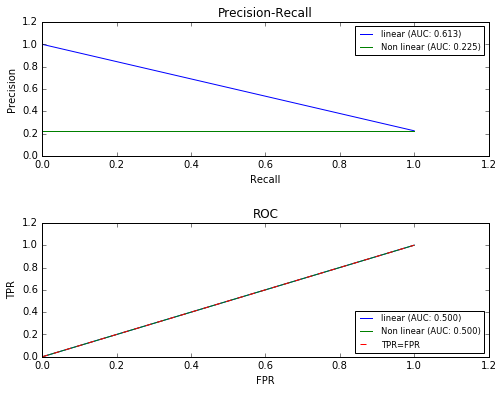

In [46]:
sub = syn.getSubmission(2363293)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df.true_class, df.belief_gen)

### Example 2 : binary predictions

linear interpolation (AUC: 0.457)
Non-linear interpolation (AUC: 0.275)


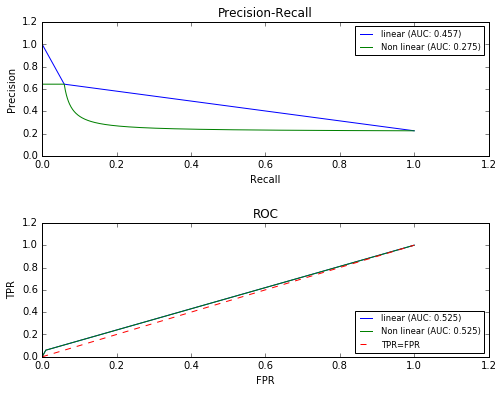

In [17]:
sub = syn.getSubmission(2363303)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df.true_class, df.belief_gen)

### Example 3 : less skewed scores

linear interpolation (AUC: 0.261)
Non-linear interpolation (AUC: 0.258)


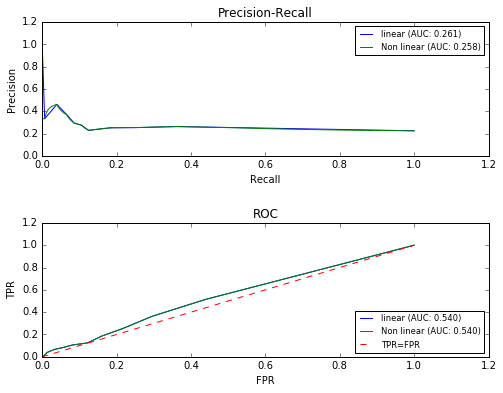

In [18]:
sub = syn.getSubmission(2364533)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df.true_class, df.belief_gen)

### Example 4 : 670 uniq scores

linear interpolation (AUC: 0.381)
Non-linear interpolation (AUC: 0.381)


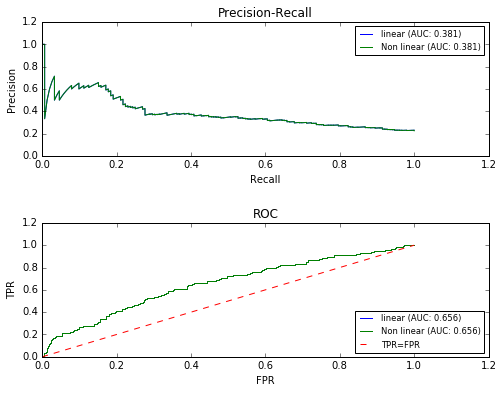

In [19]:
sub = syn.getSubmission(2368533)
df = pandas.DataFrame.from_csv(sub.filePath).reset_index()
df = df.merge(truth_df[['true_class','ID', 'Response']], left_on="ID", right_on="ID", how="outer")
__temp_plot(df.true_class, df.belief_gen)

### Testing --  When truth == prediction (May 9, 2016)

reported case by Tom  

linear interpolation (AUC: 1.000)
Non-linear interpolation (AUC: 0.989)


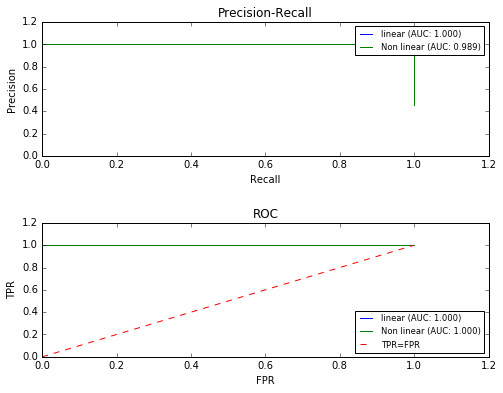

In [22]:
pred = np.concatenate([np.repeat(1,25), np.repeat(0,30)])
truth = pred
__temp_plot(truth, pred)

#### Testing Another case 
reported by Tom - possible bug

In [48]:
sub1 = syn.getSubmission(7180273)
sub1 = pandas.DataFrame.from_csv(sub1.filePath).reset_index()
sub1['pred'] = sub1.SHEDDING_SC1

sub2 = syn.getSubmission(7154754)
sub2 = pandas.DataFrame.from_csv(sub2.filePath).reset_index()
sub2['pred'] = sub2.SHEDDING_SC1

truth = syn.get('syn5705153')
truth = pandas.DataFrame.from_csv(truth.path).reset_index()
truth['true_class'] = truth.SHEDDING_SC1

linear interpolation (AUC: 0.873)
Non-linear interpolation (AUC: 0.852)


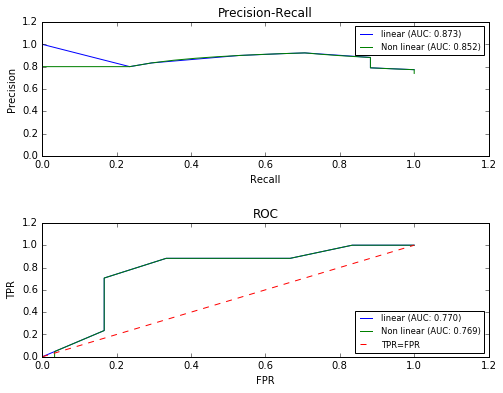

-- Block wise true positive densities-----

   block  blockValue  block_numElements  block_truePos  block_truePos_density  \
0      1    1.000000                5.0            4.0               0.800000   
1      2    0.857143                1.0            1.0               1.000000   
2      3    0.750000                4.0            4.0               1.000000   
3      4    0.600000                2.0            2.0               1.000000   
4      5    0.571429                1.0            1.0               1.000000   
5      6    0.500000                4.0            3.0               0.750000   
6      7    0.375000                1.0            0.0               0.000000   
7      8    0.285714                1.0            0.0               0.000000   
8      9    0.250000                3.0            2.0               0.666667   
9     10    0.000000                1.0            0.0               0.000000   

   cum_numElements  cum_truePos  
0              5.0          4.

In [49]:
data = sub1.merge(truth, left_on="SUBJECTID", right_on="SUBJECTID", how="outer")
__temp_plot(data.true_class, data.pred, debug=True)